In [1]:
!pip install hotelling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hotelling.stats as t2_stats
import scipy.stats as ss


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/Colab Notebooks/UCL/Thesis/

/content/drive/MyDrive/Colab Notebooks/UCL/Thesis


In [ ]:
experiment_number = 1

In [ ]:
latents_df = pd.read_csv(f'./vpr_students/output/hasc/hasc/experiment_{experiment_number}/all_latent_values_level_0.csv')
latents_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
latents = np.array(latents_df.iloc[:,:])[:,1:]
print(latents.shape)

NameError: ignored

In [5]:
def to_seconds(min_and_sec):
  min_and_sec = str(min_and_sec)
  minutes, seconds = min_and_sec.split('.')
  minutes, seconds = int(minutes), int(seconds)
  return 60*minutes + seconds

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [6]:
X_raw = pd.read_csv('./hasc-111018-165936-acc.csv', delimiter=',', header= None)
Y = pd.read_csv('./hasc-111018-165936.csv', header=None)
X = X_raw.iloc[:,:]
X_1d = np.linalg.norm(X.iloc[:,1:], axis=1)

labels = np.concatenate((Y.iloc[:,0], Y.iloc[:,1])) 
labels = np.array(labels[np.logical_not(np.isnan(labels))])
time_list = X.iloc[:,0]
correct_labels = [0]
for label in labels:
  correct_labels.append(np.where(time_list == find_nearest(time_list, label))[0][0])

# Classification metric

In [7]:
def classification_metric(preds,targets, margin=5, multiple_annotators = False):
  if len(preds) == 0:
    return 0,0,0
  if multiple_annotators:
    n_annotators = len(targets)
    all_tp = 0
    avg_recall = 0
    all_changepoints = []
    for labels in targets.values():
      for label in labels:
        all_changepoints.append(label)

    #average recall
    for labels in targets.values():
      true_positives = {label:0 for label in labels}
      for pred in preds:
        for label in labels:
          if abs(pred-label) <= margin:
            if true_positives[label] == 0:
              true_positives[label] = 1
      tp = sum(true_positives.values())
      avg_recall += (1/n_annotators)*(tp/len(labels))

    #average precision
    true_positives = {target:0 for target in all_changepoints}

    for pred in preds:
      for target in all_changepoints:
        if abs(pred-target) <= margin:
          if true_positives[target] == 0:
            true_positives[target] = 1
            
          break
    tp = sum(true_positives.values())
    avg_precision = tp/len(preds)
  

    if avg_precision == 0 and avg_recall == 0:
      f_score = 0
    else:
      f_score = 2*avg_precision*avg_recall/(avg_precision + avg_recall)
    return f_score, avg_precision, avg_recall

  else:
    true_positives = {target:0 for target in targets}

    for pred in preds:
      for target in targets:
        if abs(pred-target) <= margin:
          if true_positives[target] == 0:
            true_positives[target] = 1
          break
    tp = sum(true_positives.values())
    precision = tp/len(preds)
    recall = tp / len(targets)
    if precision == 0 and recall == 0:
      f_score = 0
    else:
      f_score = 2*precision*recall/(precision + recall)

    return f_score, precision, recall

# Compute p_values

In [8]:
def compute_p_values(latents, s_dim, window_length, sigma_noise=0.001):
  # np.random.seed(1) is already good
  # np.random.seed(1)
  levels = latents.shape[0]
  T = latents.shape[0]
  p_values = np.ones((T))
  p_values_mov_avg = np.ones((T))
  t2_stats_values = np.zeros((T)) 
  for t in range(window_length+window_length,T-window_length):
    z_left = latents[t-window_length:t] + np.random.normal(0,sigma_noise,(window_length,s_dim))
    z_right = latents[t:t+window_length] + np.random.normal(0,sigma_noise,(window_length,s_dim))
    # p_values[t] = HotellingT2(z_left, z_right)
    if s_dim == 1:
      equal_var = True
      t2_stats_values[t], p_values[t] = ss.ttest_ind(z_left,z_right, equal_var=equal_var)
    else:
      t2_stats_values[t], _, p_values[t], _ = t2_stats.hotelling_t2(z_left, z_right)
    if t == window_length+window_length:
      p_value_mov_avg = p_values[t]
    else:
      p_value_mov_avg = 0.9*p_value_mov_avg + 0.1*p_values[t]
    p_values_mov_avg[t] = p_value_mov_avg

  return p_values,p_values_mov_avg,t2_stats_values

In [9]:
# correct_labels

def plot_p_values_certainty(p_values,  window_length):
  labels_without_first_sample = correct_labels[1:]
  stack_p_values = np.zeros((len(labels_without_first_sample), window_length))
  offset = int(window_length/2)

  for idx,changepoint in enumerate(labels_without_first_sample):
    stack_p_values[idx] = p_values[changepoint-offset:changepoint+offset+1]

  means = np.mean(stack_p_values, axis=0)
  stds = np.std(stack_p_values, axis=0)
  x_axis = np.arange(window_length)
  fig, ax = plt.subplots(1, 1, figsize=(35,10))
  fig.suptitle('p value mean and standard deviation around ground truth changepoint')
  ax.errorbar(x_axis, means, stds, mec = 'g', fmt='-o')
  ax.axvline(x=offset, color='r', linestyle='-', lw='2', label='Ground truth')
  ax.set_xlabel("Time")
  ax.set_ylabel("p value")
  ax.legend()



# Make predictions based on p values

In [10]:
def make_predictions_hotelling(p_values, decision, n_consecutive, threshold=0.05):
  T = p_values.shape[0]
  preds_Hotelling = [0]
  cp_detected = False
  low_p_accum = 0
  lowest_p_value = 1
  highest_t2_stat = 0
  first_t_cp = True

  for t in range(0, T):
    p_value = p_values[t]
    t2_stat = t2_stats_values[t]

    if cp_detected and p_value > threshold:
      if decision[0] == "use_highest_f_stat":
      # preds_Hotelling.append(t_of_lowest_p_value)
        preds_Hotelling.append(t_of_highest_t2_stat)
      elif decision[0] == "start_and_stop":
        preds_Hotelling.append(t_init+decision[1])
        preds_Hotelling.append(t-decision[1])
      else:
        preds_Hotelling.append(t_init+decision)
      cp_detected = False

    if p_value < threshold:
      low_p_accum += 1
      # if p_value < lowest_p_value:
      #   lowest_p_value = p_value
      #   t_of_lowest_p_value = t
      if t2_stat > highest_t2_stat:
        highest_t2_stat = t2_stat
        t_of_highest_t2_stat = t
      if first_t_cp:
        t_init = t
        first_t_cp = False

    else:
      lowest_p_value = 1
      low_p_accum = 0
      highest_t2_stat = 0
      first_t_cp = True

    if low_p_accum >= n_consecutive:
      cp_detected = True
  return preds_Hotelling

# Visualize

In [ ]:
s_dim, window_length = 20, 25
p_values,p_values_mov_avg,t2_stats_values = compute_p_values(latents, s_dim, window_length)

In [ ]:
window_length = 25
sequence_length = 100



for margin in [60, 100, 200]:
  for idx, p_val_type in enumerate(("p_values", "p_values_mov_avg")):
    best_f_score = 0
    best_decision = None
    best_n_consecutive = None
    best_threshold = None
    for decision in [("use_highest_f_stat",0), ("use_highest_f_stat",window_length),("start_and_stop",0),("start_and_stop",window_length), ("start_and_stop",2*window_length)]:
      for n_consecutive in (window_length, 2*window_length, sequence_length, 2*sequence_length, 3*sequence_length, 4*sequence_length):
        for threshold in (0.01, 0.02, 0.05, 0.1, 0.2):
          if p_val_type == "p_values":
            changepoints_hotelling = make_predictions_hotelling(p_values, decision, n_consecutive, threshold)
          else:
            changepoints_hotelling = make_predictions_hotelling(p_values_mov_avg, decision, n_consecutive, threshold)
          f_score, precision, recall = classification_metric(changepoints_hotelling,correct_labels, margin, multiple_annotators = False)
          # print(f"f_score: {f_score}, p_val_type: {p_val_type}, decision: {decision}, n_consecutive:{n_consecutive}, threshold: {threshold}  ")
          if f_score >= best_f_score:
            best_f_score = f_score
            best_decision = decision
            best_n_consecutive = n_consecutive
            best_threshold = threshold
            best_p_val_type = p_val_type
    print(f"When we take {p_val_type}:")
    print(f"Best f_score for margin = {margin} is {best_f_score}")
    print(f"Best params: decision {best_decision}, n_consecutive: {best_n_consecutive}, threshold: {best_threshold}")


  

When we take p_values:
Best f_score for margin = 60 is 0.4742268041237114
Best params: decision ('start_and_stop', 50), n_consecutive: 400, threshold: 0.02
When we take p_values_mov_avg:
Best f_score for margin = 60 is 0.4646464646464647
Best params: decision ('start_and_stop', 50), n_consecutive: 300, threshold: 0.02
When we take p_values:
Best f_score for margin = 100 is 0.5436893203883495
Best params: decision ('start_and_stop', 50), n_consecutive: 300, threshold: 0.02
When we take p_values_mov_avg:
Best f_score for margin = 100 is 0.5252525252525253
Best params: decision ('start_and_stop', 50), n_consecutive: 300, threshold: 0.02
When we take p_values:
Best f_score for margin = 200 is 0.5825242718446602
Best params: decision ('start_and_stop', 0), n_consecutive: 300, threshold: 0.02
When we take p_values_mov_avg:
Best f_score for margin = 200 is 0.5794392523364487
Best params: decision ('start_and_stop', 0), n_consecutive: 200, threshold: 0.01


In [ ]:
preds_entire_dataset = True
if preds_entire_dataset:
  save_location_prefix = "entire_dataset_"
else:
  save_location_prefix = ""
experiment_number = 17
s_dim, window_length, sequence_length = 5, 25, 200
n_levels = 3
T = X.shape[0]
latents_all_level_combined = np.zeros((T, s_dim*n_levels))

for level in range(n_levels):
  print(f"LEVEL {level}")
  latents_df = pd.read_csv(f'./vpr_students/output/hasc/hasc/experiment_{experiment_number}/{save_location_prefix}all_latent_values_level_{level}.csv')
  latents = np.array(latents_df.iloc[:,:])[:,1:]
  
  p_values,p_values_mov_avg,t2_stats_values = compute_p_values(latents, s_dim, window_length)
  latents_all_level_combined[:,level*s_dim:(level+1)*s_dim] = latents


  for margin in [60, 100, 200]:
    for idx, p_val_type in enumerate(("p_values", "p_values_mov_avg")):
      best_f_score = 0
      best_decision = None
      best_n_consecutive = None
      best_threshold = None
      for decision in [("use_highest_f_stat",0), ("use_highest_f_stat",window_length),("start_and_stop",0),("start_and_stop",window_length), ("start_and_stop",2*window_length)]:
        for n_consecutive in (window_length, 2*window_length, sequence_length, 2*sequence_length, 3*sequence_length, 4*sequence_length):
          for threshold in (0.01, 0.02, 0.05, 0.1, 0.2):
            if p_val_type == "p_values":
              changepoints_hotelling = make_predictions_hotelling(p_values, decision, n_consecutive, threshold)
            else:
              changepoints_hotelling = make_predictions_hotelling(p_values_mov_avg, decision, n_consecutive, threshold)
            f_score, precision, recall = classification_metric(changepoints_hotelling,correct_labels, margin, multiple_annotators = False)
            # print(f"f_score: {f_score}, p_val_type: {p_val_type}, decision: {decision}, n_consecutive:{n_consecutive}, threshold: {threshold}  ")
            if f_score >= best_f_score:
              best_f_score = f_score
              best_decision = decision
              best_n_consecutive = n_consecutive
              best_threshold = threshold
              best_p_val_type = p_val_type
      print(f"When we take {p_val_type}:")
      print(f"Best f_score for margin = {margin} is {best_f_score}")
      print(f"Best params: decision {best_decision}, n_consecutive: {best_n_consecutive}, threshold: {best_threshold}")


print(f"------------------------------------------------")

print(f"When merging all latents together:")

p_values,p_values_mov_avg,t2_stats_values = compute_p_values(latents_all_level_combined, s_dim*n_levels, window_length)

for margin in [60, 100, 200]:
  for idx, p_val_type in enumerate(("p_values", "p_values_mov_avg")):
    best_f_score = 0
    best_decision = None
    best_n_consecutive = None
    best_threshold = None
    for decision in [("use_highest_f_stat",0), ("use_highest_f_stat",window_length),("start_and_stop",0),("start_and_stop",window_length), ("start_and_stop",2*window_length)]:
      for n_consecutive in (window_length, 2*window_length, sequence_length, 2*sequence_length, 3*sequence_length, 4*sequence_length):
        for threshold in (0.01, 0.02, 0.05, 0.1, 0.2):
          if p_val_type == "p_values":
            changepoints_hotelling = make_predictions_hotelling(p_values, decision, n_consecutive, threshold)
          else:
            changepoints_hotelling = make_predictions_hotelling(p_values_mov_avg, decision, n_consecutive, threshold)
          f_score, precision, recall = classification_metric(changepoints_hotelling,correct_labels, margin, multiple_annotators = False)
          # print(f"f_score: {f_score}, p_val_type: {p_val_type}, decision: {decision}, n_consecutive:{n_consecutive}, threshold: {threshold}  ")
          if f_score >= best_f_score:
            best_f_score = f_score
            best_decision = decision
            best_n_consecutive = n_consecutive
            best_threshold = threshold
            best_p_val_type = p_val_type
    print(f"When we take {p_val_type}:")
    print(f"Best f_score for margin = {margin} is {best_f_score}")
    print(f"Best params: decision {best_decision}, n_consecutive: {best_n_consecutive}, threshold: {best_threshold}")




LEVEL 0
When we take p_values:
Best f_score for margin = 60 is 0.30188679245283023
Best params: decision ('use_highest_f_stat', 25), n_consecutive: 50, threshold: 0.05
When we take p_values_mov_avg:
Best f_score for margin = 60 is 0.3151515151515152
Best params: decision ('start_and_stop', 50), n_consecutive: 200, threshold: 0.1
When we take p_values:
Best f_score for margin = 100 is 0.3371647509578544
Best params: decision ('use_highest_f_stat', 25), n_consecutive: 50, threshold: 0.01
When we take p_values_mov_avg:
Best f_score for margin = 100 is 0.4121212121212121
Best params: decision ('start_and_stop', 50), n_consecutive: 200, threshold: 0.1
When we take p_values:
Best f_score for margin = 200 is 0.41059602649006616
Best params: decision ('start_and_stop', 0), n_consecutive: 200, threshold: 0.2
When we take p_values_mov_avg:
Best f_score for margin = 200 is 0.46060606060606063
Best params: decision ('start_and_stop', 0), n_consecutive: 200, threshold: 0.1
LEVEL 1
When we take p_va

In [ ]:
level = 2
preds_entire_dataset = True
if preds_entire_dataset:
  save_location_prefix = "entire_dataset_"
else:
  save_location_prefix = ""
latents_df = pd.read_csv(f'./vpr_students/output/hasc/hasc/experiment_{experiment_number}/{save_location_prefix}all_latent_values_level_{level}.csv')
latents = np.array(latents_df.iloc[:,:])[:,1:]
p_values,p_values_mov_avg,t2_stats_values = compute_p_values(latents, s_dim, window_length)
changepoints_hotelling = make_predictions_hotelling(p_values, ("start_and_stop",25), 400, 0.1)
print(classification_metric(changepoints_hotelling,correct_labels, 100, multiple_annotators = False))


(0.5825242718446602, 0.8108108108108109, 0.45454545454545453)


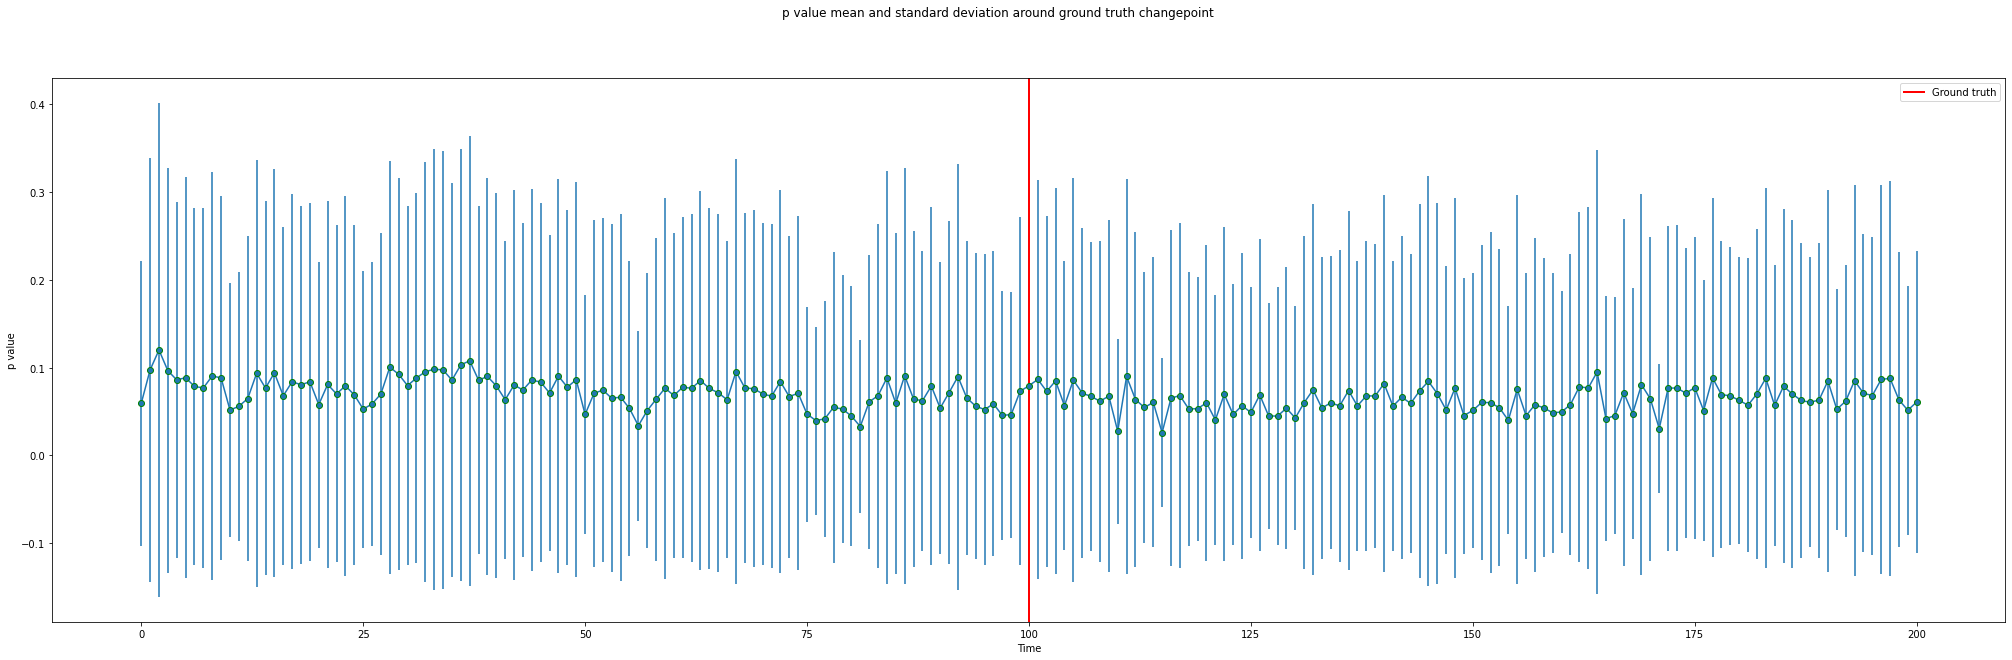

In [ ]:
plot_p_values_certainty(p_values,  window_length=201)

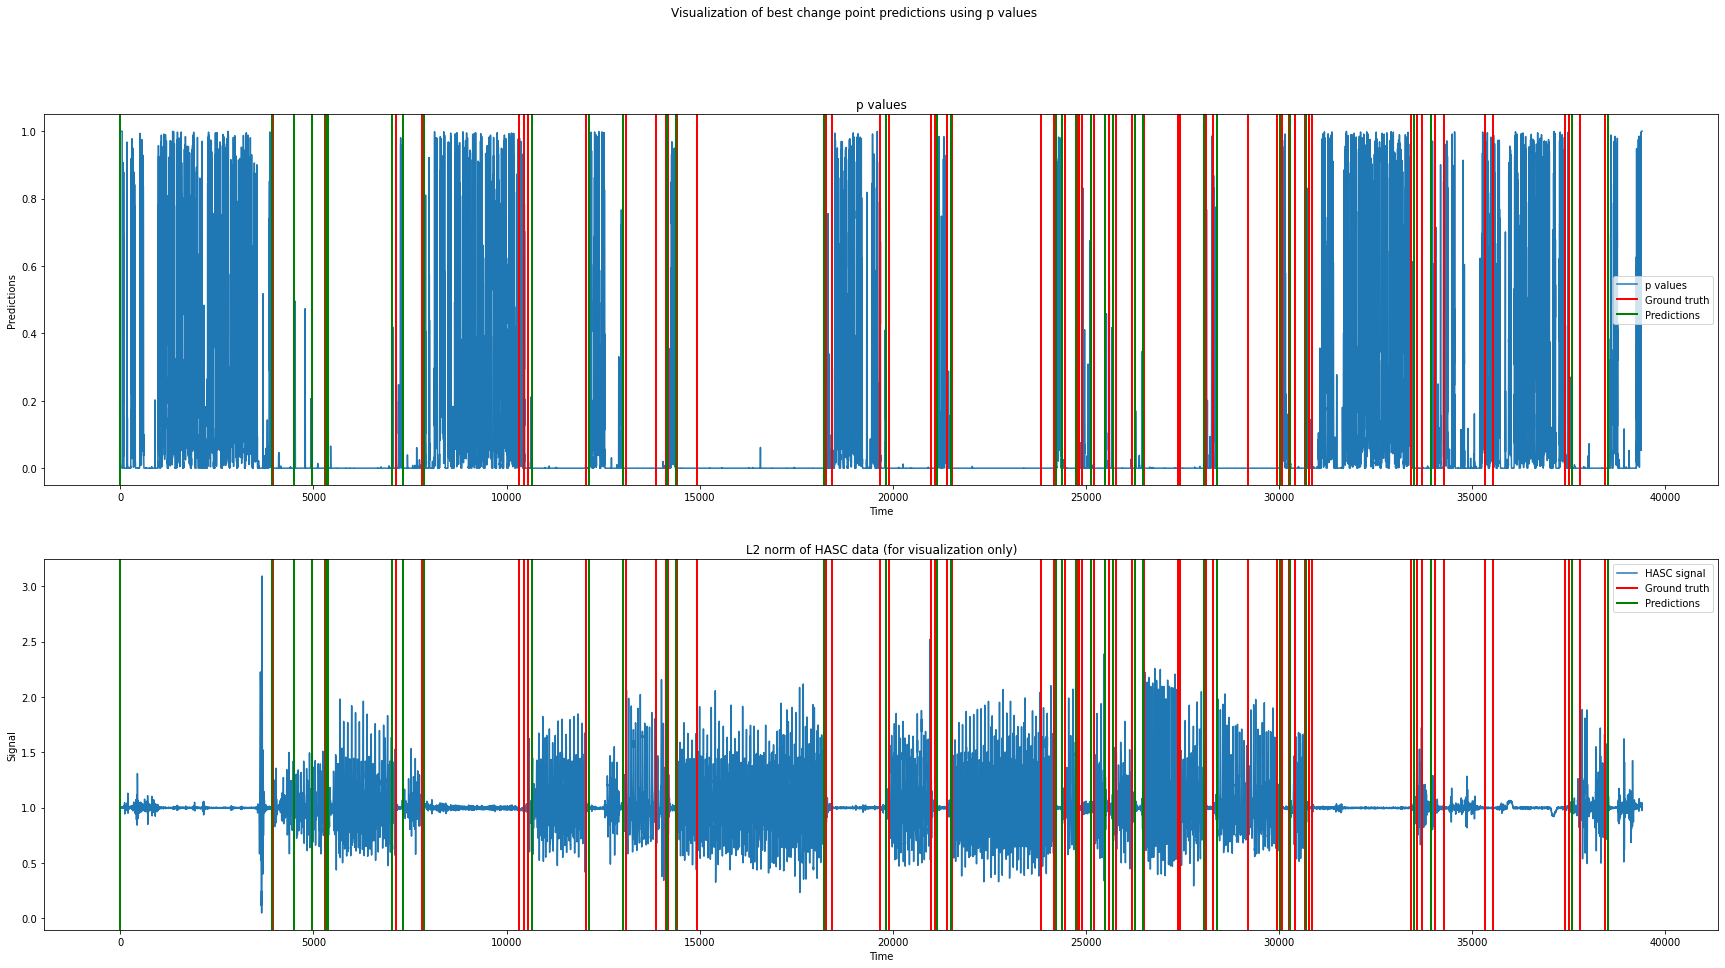

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(30,15))
fig.suptitle(f'Visualization of best change point predictions using p values')

axs[0].plot(p_values, label='p values')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Predictions")

axs[1].plot(X_1d, label='HASC signal')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Signal")


# axs[2].plot(p_values_mov_avg, lw='2', label='Moving average p values')
# axs[2].set_xlabel("Time")

axs[0].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')
axs[0].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')
axs[1].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')
axs[1].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')


# axs[2].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')
# axs[2].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')

for changepoint in correct_labels:
  axs[0].axvline(x=changepoint, color='r', lw='2')
  axs[1].axvline(x=changepoint, color='r', lw='2')
  # axs[2].axvline(x=changepoint, color='r', lw='2')
  
for changepoint in changepoints_hotelling:
  axs[0].axvline(x=changepoint, color='g', lw='2')
  axs[1].axvline(x=changepoint, color='g', lw='2')

axs[0].set_title("p values")
axs[1].set_title("L2 norm of HASC data (for visualization only)")
# axs[2].set_title("Moving average of p values")
axs[0].legend()
axs[1].legend()
# axs[2].legend()



# Using Hotelling on the raw data

In [20]:
p_values,p_values_mov_avg,t2_stats_values = compute_p_values(X.iloc[:,1:], 3, 25)


In [21]:
changepoints_hotelling = make_predictions_hotelling(p_values, ("start_and_stop",25), 400, 0.1)

In [27]:
window_length = 25
sequence_length = 100
p_values,p_values_mov_avg,t2_stats_values = compute_p_values(X.iloc[:,1:], 3, window_length)


for margin in [60, 100, 200]:
  for idx, p_val_type in enumerate(("p_values", "p_values_mov_avg")):
    best_f_score = 0
    best_decision = None
    best_n_consecutive = None
    best_threshold = None
    for decision in [("use_highest_f_stat",0), ("use_highest_f_stat",window_length),("start_and_stop",0),("start_and_stop",window_length), ("start_and_stop",2*window_length)]:
      for n_consecutive in (window_length, 2*window_length, sequence_length, 2*sequence_length, 3*sequence_length, 4*sequence_length):
        for threshold in (0.01, 0.02, 0.05, 0.1, 0.2):
          if p_val_type == "p_values":
            changepoints_hotelling = make_predictions_hotelling(p_values, decision, n_consecutive, threshold)
          else:
            changepoints_hotelling = make_predictions_hotelling(p_values_mov_avg, decision, n_consecutive, threshold)
          f_score, precision, recall = classification_metric(changepoints_hotelling,correct_labels, margin, multiple_annotators = False)
          # print(f"f_score: {f_score}, p_val_type: {p_val_type}, decision: {decision}, n_consecutive:{n_consecutive}, threshold: {threshold}  ")
          if f_score >= best_f_score:
            best_f_score = f_score
            best_decision = decision
            best_n_consecutive = n_consecutive
            best_threshold = threshold
            best_p_val_type = p_val_type
    print(f"When we take {p_val_type}:")
    print(f"Best f_score for margin = {margin} is {best_f_score}")
    print(f"Best params: decision {best_decision}, n_consecutive: {best_n_consecutive}, threshold: {best_threshold}")

When we take p_values:
Best f_score for margin = 60 is 0.47328244274809156
Best params: decision ('start_and_stop', 0), n_consecutive: 200, threshold: 0.2
When we take p_values_mov_avg:
Best f_score for margin = 60 is 0.4793388429752066
Best params: decision ('start_and_stop', 25), n_consecutive: 200, threshold: 0.02
When we take p_values:
Best f_score for margin = 100 is 0.534351145038168
Best params: decision ('start_and_stop', 25), n_consecutive: 200, threshold: 0.2
When we take p_values_mov_avg:
Best f_score for margin = 100 is 0.5528455284552845
Best params: decision ('start_and_stop', 25), n_consecutive: 200, threshold: 0.05
When we take p_values:
Best f_score for margin = 200 is 0.5225225225225225
Best params: decision ('start_and_stop', 0), n_consecutive: 300, threshold: 0.1
When we take p_values_mov_avg:
Best f_score for margin = 200 is 0.5233644859813085
Best params: decision ('start_and_stop', 0), n_consecutive: 300, threshold: 0.05


In [29]:
changepoints_hotelling = make_predictions_hotelling(p_values, ("start_and_stop",25), 200, 0.2)

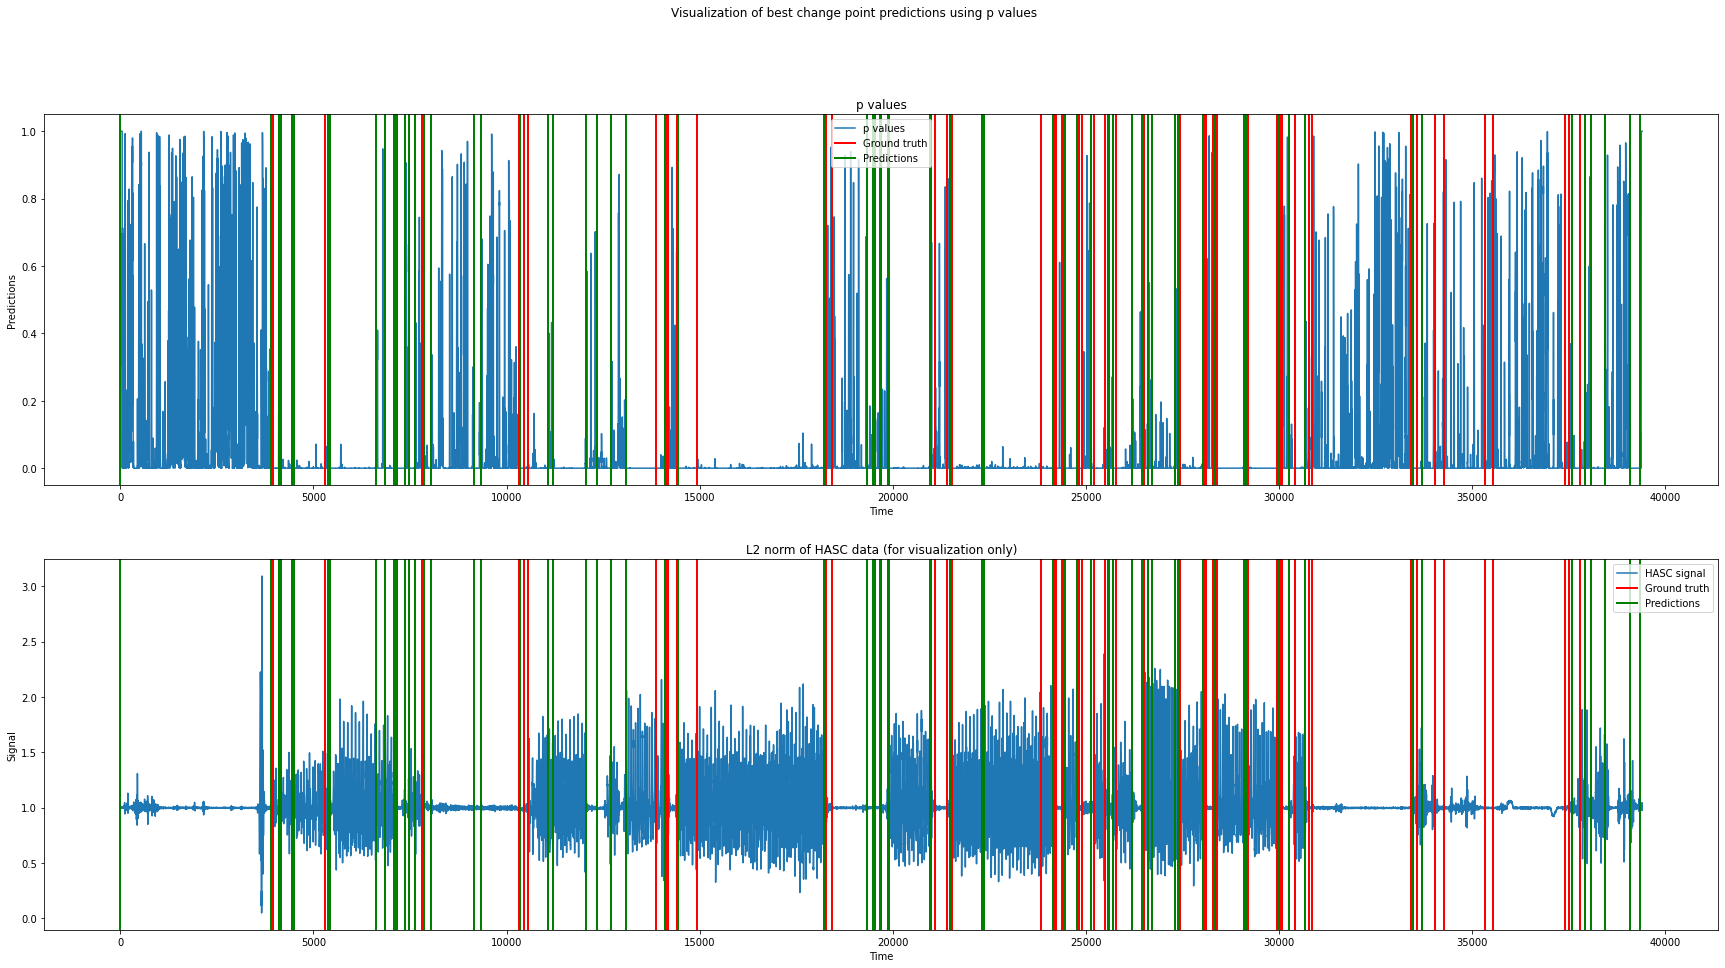

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(30,15))
fig.suptitle(f'Visualization of best change point predictions using p values')

axs[0].plot(p_values, label='p values')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Predictions")

axs[1].plot(X_1d, label='HASC signal')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Signal")


# axs[2].plot(p_values_mov_avg, lw='2', label='Moving average p values')
# axs[2].set_xlabel("Time")

axs[0].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')
axs[0].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')
axs[1].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')
axs[1].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')


# axs[2].axvline(x=changepoints_hotelling[0], color='g', linestyle='-', lw='2', label='Predictions')
# axs[2].axvline(x=correct_labels[0], color='r', linestyle='-', lw='2', label='Ground truth')

for changepoint in correct_labels:
  axs[0].axvline(x=changepoint, color='r', lw='2')
  axs[1].axvline(x=changepoint, color='r', lw='2')
  # axs[2].axvline(x=changepoint, color='r', lw='2')
  
for changepoint in changepoints_hotelling:
  axs[0].axvline(x=changepoint, color='g', lw='2')
  axs[1].axvline(x=changepoint, color='g', lw='2')

axs[0].set_title("p values")
axs[1].set_title("L2 norm of HASC data (for visualization only)")
# axs[2].set_title("Moving average of p values")
axs[0].legend()
axs[1].legend()
# axs[2].legend()

